# Clustering and Association Rule Mining
Assignment instructions: https://github.com/vesavvo/dkko/blob/main/assignments/Assignment_Clustering_and_association_rule_mining.md

## 1. Business Understanding

## 2. Data Understanding

The raw data is in the directory `./drone_delivery/` and consists of the following files:
- `drone_cust_locations.csv`
- `drone_deliveries.csv`
The first file contains locations of clients and the second file contains sales data for products. 

### Client locations dataset

The data is locations as x and y coordinates separated by a semicolon. In the following code cell the data is read and a scatterplot is created to visualize to locations of the clients.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mlxtend.frequent_patterns import apriori, association_rules
import time

# Read csv file for client locations
df = pd.read_csv('./drone_delivery/drone_cust_locations.csv', sep=';')
df.head()


,clientid,x,y
0,1,622.771572,164.857623
1,2,416.357298,630.193634
2,3,292.735020,567.333231
3,4,737.211288,166.225676
4,5,540.475375,682.912298


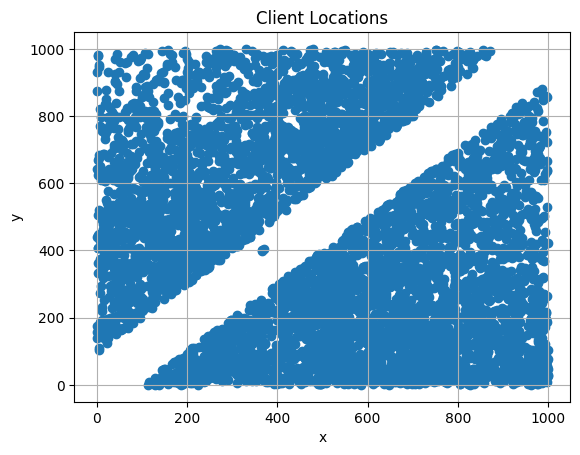

Empty values in the dataset:
clientid    0
x           0
y           0
dtype: int64


In [551]:
# Scatterplot of client locations
plt.scatter(df['x'], df['y'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Client Locations')
plt.grid()
plt.show()
# Print empty values in the dataset
print(f'Empty values in the dataset:\n{df.isnull().sum()}')

The scatterplot of the data shows that there are two clear clusters of clients. There is an empty are between the clusters suggesting that there is a geographical area where there are almost no clients. 

### Sales product dataset

The sales data set contains columns for products: Prod1, Prod2, ... A row represents transactions, that is one clien´s purchases. The value in the columns are 1 or 0 representing whether the client bought the product or not. This dataset is separated by a comma. The following code cell reads the data and shows the first rows of the data.

In [552]:
# Read csv file for sales data
sales_df = pd.read_csv('./drone_delivery/drone_prod_groups.csv', sep=',')
sales_df.head()

,ID,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,...,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,2,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,1,1,1
2,3,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,4,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,5,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,1


## 3. Data Preparation

The datasets are both in correct format and there are no missing values. Only the ID columns should be dropped in both datasets. The client location dataset is used for clustering and the sales dataset is used for association rule mining. There is no target variable in the datasets. 

The Apriori algorithm works with binary data as is in the dataset, but some methods prefer boolean data. So even if its strictly speaking not necessary, the data is converted to boolean data as there otherwise would be deprecation warnings when using the mlxtend library.

In [553]:
# Drop ID column
df = df.drop(columns=['clientid'])
df.head()

,x,y
0,622.771572,164.857623
1,416.357298,630.193634
2,292.735020,567.333231
3,737.211288,166.225676
4,540.475375,682.912298


In [554]:
# Drop ID column
sales_df = sales_df.drop(columns=['ID'])
sales_df = sales_df.astype(bool)
sales_df.head()

,Prod1,Prod2,Prod3,Prod4,Prod5,Prod6,Prod7,Prod8,Prod9,Prod10,Prod11,Prod12,Prod13,Prod14,Prod15,Prod16,Prod17,Prod18,Prod19,Prod20
0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,True,True,True,True,True
2,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,True
3,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True


## 4. Modeling

In this section the clustering and association rule mining are performed. The clustering is done using the K-means algorithm to find the best geographical locations for the drone depot stations. Association rule mining is done using the Apriori algorithm to find the best product combinations to be sold in the drone delivery service.

### Clustering
The clustering is done using the K-means algorithm to find the best geographical locations for the drone depot stations. First the locations for three drone depot stations (clusters) are determined. That information is then attached to each client as an additional column in the dataset.

In [555]:
# K-means clustering for three drone depot stations, copy original dataset for later use
df_three = df.copy()
model = KMeans(n_clusters=3, random_state=123)
model.fit(df_three)
print(f'Cluster centers:\n{model.cluster_centers_}')

Cluster centers:
[[198.53635396 382.88575615]
 [548.00601882 787.2438163 ]
 [702.21311616 211.32734145]]


In [556]:
# Attach cluster labels to the original dataset
df_three['cluster'] = model.labels_
df_three.head(10)

,x,y,cluster
0,622.771572,164.857623,2
1,416.357298,630.193634,1
2,292.735020,567.333231,0
3,737.211288,166.225676,2
4,540.475375,682.912298,1
5,535.469492,318.439661,2
6,640.380050,870.833221,1
7,235.772075,359.048203,0
8,481.896884,661.491838,1
9,730.032789,312.177817,2


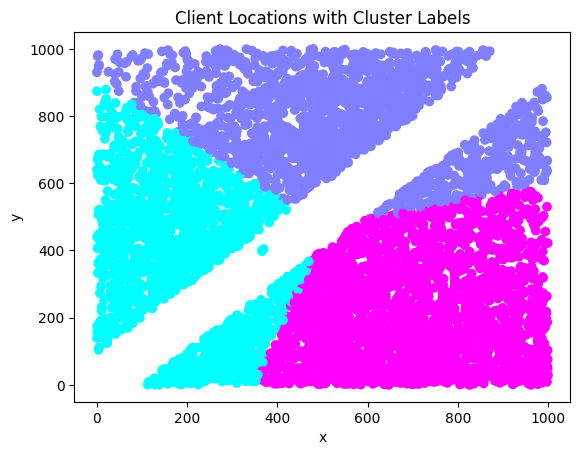

In [557]:
# Scatterplot of client locations with cluster labels
plt.scatter(df_three['x'], df_three['y'], c=df_three['cluster'], cmap='cool')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Client Locations with Cluster Labels')
plt.show()

Next the number of clusters is inspected and the computation time is measured for different number of clusters. The optimal number of clusters is then determined using the elbow method.

In [558]:
# Cluster values 4, 6, 8, 10, 12, 14, 16, 18 and 20 and measure computation time
cluster_values = [4, 6, 8, 10, 12, 14, 16, 18, 20]
for k in cluster_values:
    start_time = time.time()
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(df)
    end_time = time.time()
    print(f'Computation time for {k} clusters: {end_time - start_time:.4f} seconds')

Computation time for 4 clusters: 0.0068 seconds
Computation time for 6 clusters: 0.0050 seconds
Computation time for 8 clusters: 0.0073 seconds
Computation time for 10 clusters: 0.0059 seconds
Computation time for 12 clusters: 0.0061 seconds
Computation time for 14 clusters: 0.0078 seconds
Computation time for 16 clusters: 0.0076 seconds
Computation time for 18 clusters: 0.0084 seconds
Computation time for 20 clusters: 0.0093 seconds


The computation time does not really increase in a significant way as the number of clusters increases. The complexity of the K-means algorithm is O(n*k*i) where n is the number of data points, k is the number of clusters and i is the number of iterations until convergence. This means that only in large datasets would there be a significant increase in computation time as the number of clusters increases, but in this case the dataset is small and the computation time is not significantly affected by the number of clusters.

The elbow method can however be used to determine the optimal number of clusters by plotting WCSS (within-cluster sum of squares) against the number of clusters. WCSS measures the total distance between each point and the centroid of its cluster. As the number of clusters increases, WCSS decreases because the points are closer to their centroids. However, after a certain point, the decrease in WCSS becomes less significant, which is where the "elbow" occurs in the plot. That point indicates the optimal number of clusters.

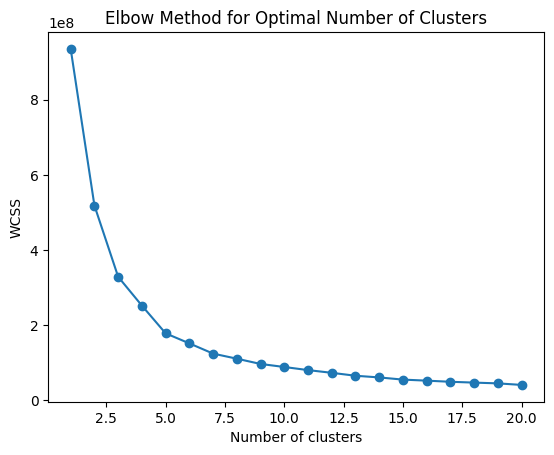

In [559]:
# Elbow method to determine optimal number of clusters
wcss = []
for i in range(1, 21):
    model = KMeans(n_clusters=i, random_state=123)
    model.fit(df)
    wcss.append(model.inertia_)
plt.plot(range(1, 21), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

Looking at the plot above, the optimal number of clusters would seem to be 5 where the elbow point is. In the code cell below, the final clustering is done with 5 clusters and the cluster centers are printed. A new dataset is created with the cluster labels and a scatterplot is created to visualize the clusters.

In [560]:
# Clustering with 5 clusters and print cluster centers
model = KMeans(n_clusters=5, random_state=123)
model.fit(df)
print("Cluster centers:\n", model.cluster_centers_)

Cluster centers:
 [[435.9320266  148.09913438]
 [490.78823606 826.19764288]
 [802.92486315 151.21711141]
 [806.84590142 530.53930161]
 [162.32248608 499.13337299]]


In [561]:
# Attach cluster labels to the original dataset
df_five = df.copy()
df_five['cluster'] = model.labels_
df_five.head(10)

,x,y,cluster
0,622.771572,164.857623,2
1,416.357298,630.193634,1
2,292.735020,567.333231,4
3,737.211288,166.225676,2
4,540.475375,682.912298,1
5,535.469492,318.439661,0
6,640.380050,870.833221,1
7,235.772075,359.048203,4
8,481.896884,661.491838,1
9,730.032789,312.177817,2


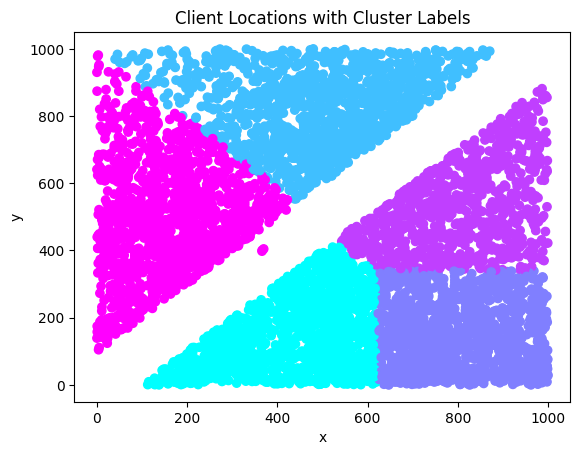

In [562]:
# Scatterplot of client locations with cluster labels
plt.scatter(df_five['x'], df_five['y'], c=df_five['cluster'], cmap='cool')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Client Locations with Cluster Labels')
plt.show()

#### Comparing Clusters with Agglomerative Clustering

Next the K-means clustering is compared with Agglomerative Clustering. The number of clusters is inspected and the computation time is measured for different number of clusters. Dendrograms are plotted to visualize the hierarchical structure of the clusters.

In [ ]:
# Agglomerative Clustering with 2, 3, 4, 5, 6, 7, 8, 9 and 10 clusters and measure computation time
cluster_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in cluster_values:
    start_time = time.time()
    model = AgglomerativeClustering(n_clusters=k)
    model.fit(df)
    end_time = time.time()
    print(f'Computation time for {k} clusters: {end_time - start_time:.4f} seconds')


Just looking at the computation times, it is clear that the K-means algorithm is much faster than the Agglomerative Clustering algorithm. The complexity of Agglomerative Clustering is O(n^3) in the worst case, which means that it can be very slow for large datasets. The dendrogram´s horizontal lines show the clusters and the vertical lines show the distance between the clusters. The longer the vertical line, the more different the clusters are. The dendrograms show that there are two main clusters in the data as there are two long vertical lines to the top most horizontal lines. Three more clusters can be seen to jump out from the two main clusters as well as from the big sample pool. 

The hierachical structure of the clusters manages outliers better than K-means, but in this case the K-means algorithm is better suited as it is easy to implement and the risk of mismatching outliers is not significant in this case. Drone depot stations are not likely to be located in areas where there are almost no clients, so the outliers are not likely to affect the results significantly.

### Association Rule Mining

The association rule mining is done to find interesting relationships between product groups. The data does not specify what exactly the products are as the columns are named Prod1, Prod2, ... but the rules can be used to find out which products are often bought together and which products are not bought together. Based on this a clear recommendation of how the company should use the results to increase revenues can be made. 

The association rule mining is done using the Apriori algorithm. First the algorithm generates frequent itemsets based on the minimum support threshold. Then the algorithm generates association rules based on the minimum confidence threshold. Different values for these can be experimented with the code cell below. 

In [564]:
# Investigating the optimal values for the minimum support and confidence thresholds for the Apriori algorithm. 
# The number of rules generated is recorded for each combination of support and confidence values. 
# The results are then sorted by the number of rules generated to find the optimal values for the thresholds.
# Threshold ranges to explore
support_values = [0.05, 0.08, 0.1, 0.12]       # min_support
confidence_values = [0.4, 0.5, 0.6, 0.7]      # min_threshold for rules

results = []

for support in support_values:
    # Generate frequent itemsets
    frequent_itemsets = apriori(sales_df, min_support=support, use_colnames=True)
    
    for confidence in confidence_values:
        # Generate rules
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence)
        
        # Record the number of rules
        results.append({
            "min_support": support,
            "min_confidence": confidence,
            "num_rules": len(rules)
        })

# Convert results to dataframe for easy inspection
results_df = pd.DataFrame(results)

# Show the results
print(results_df.sort_values(by="num_rules", ascending=False))


    min_support  min_confidence  num_rules
0          0.05             0.4          6
1          0.05             0.5          5
2          0.05             0.6          4
4          0.08             0.4          4
5          0.08             0.5          4
8          0.10             0.4          4
9          0.10             0.5          4
6          0.08             0.6          3
10         0.10             0.6          3
3          0.05             0.7          2
7          0.08             0.7          2
11         0.10             0.7          2
12         0.12             0.4          2
13         0.12             0.5          2
14         0.12             0.6          2
15         0.12             0.7          1


When considering the optimal values for the minimum support and confidence thresholds, it is important to find a balance between having too many rules and having too few rules. For lower values of support and confidence, there will be more rules generated, but many of them might not be useful. For higher values of support and confidence, there will be fewer rules generated, but they will be more useful. In this case, a minimum support of 0.1 and a minimum confidence of 0.5 seems to be a good balance as it generates a reasonable number of rules that are likely to be useful for the company.

In [565]:
# Association rules with min_support=0.1 and min_confidence=0.5
frequent_itemsets = apriori(sales_df, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules = rules.sort_values(by="confidence", ascending=False)
rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,( Prod15),( Prod9),0.11880,0.19853,0.11145,0.938131,4.725388,1.0,0.087865,12.954372,0.894663,0.541335,0.922806,0.749754
3,( Prod20),( Prod19),0.14798,0.20626,0.13476,0.910664,4.415125,1.0,0.104238,8.884845,0.907849,0.613997,0.887449,0.782007
2,( Prod19),( Prod20),0.20626,0.14798,0.13476,0.653350,4.415125,1.0,0.104238,2.457869,0.974508,0.613997,0.593144,0.782007
1,( Prod9),( Prod15),0.19853,0.11880,0.11145,0.561376,4.725388,1.0,0.087865,2.009011,0.983664,0.541335,0.502243,0.749754


Also lift should be calculated to find out which rules are more interesting. Lift is a measure of how much more likely the products in the rule are bought together than if they were independent. A lift value greater than 1 indicates that the products are more likely to be bought together than if they were independent, while a lift value less than 1 indicates that the products are less likely to be bought together than if they were independent. The higher the lift value, the more interesting the rule is.

In [566]:
# Lift calculation for the generated rules
rules['lift'] = rules['confidence'] / (rules['consequent support'])
rules = rules.sort_values(by='lift', ascending=False)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,( Prod15),( Prod9),0.11880,0.19853,0.11145,0.938131,4.725388,1.0,0.087865,12.954372,0.894663,0.541335,0.922806,0.749754
1,( Prod9),( Prod15),0.19853,0.11880,0.11145,0.561376,4.725388,1.0,0.087865,2.009011,0.983664,0.541335,0.502243,0.749754
3,( Prod20),( Prod19),0.14798,0.20626,0.13476,0.910664,4.415125,1.0,0.104238,8.884845,0.907849,0.613997,0.887449,0.782007
2,( Prod19),( Prod20),0.20626,0.14798,0.13476,0.653350,4.415125,1.0,0.104238,2.457869,0.974508,0.613997,0.593144,0.782007


## 5. Evaluation

Both the clustering and association rule mining were investigated and optimized in the last section. The optimal number of clusters was determined to be 5 using the elbow method and the optimal values for minimum support and confidence were determined to be 0.1 and 0.5 respectively by finding a balance between having too many rules and having too few rules. The lift values were also calculated to find out which rules are more interesting.

### Clustering evaluation
The silhouette coefficient is used to evaluate the quality of the clusters. The silhouette coefficient is a measure of how similar an object is to its own cluster compared to other clusters. The value ranges from -1 to 1, where a value close to 1 indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters, while a value close to -1 indicates that the object is poorly matched to its own cluster and well matched to neighboring clusters. A value of 0 indicates that the object is on the border of two clusters. The silhouette coefficient can be calculated for each data point and then averaged to get an overall silhouette score for the clustering. A higher silhouette score indicates better clustering.

In [567]:
# Silhoutte coefficient calculation for the clustering
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(df_five, model.labels_)
print(f'Silhouette Score for 5 clusters: {silhouette_avg:.4f}')

Silhouette Score for 5 clusters: 0.4182


The silhouette score for the 5 clusters is 0.42, which indicates that the clusters are not very well defined, but they are not completely random either. Looking at the initial scatterplot of the data, it is clear that there are two main clusters with clients in the data so it seems reasonable to have a silhouette score that is not very high. The amount of drone depot stations will probably also be dependant on what the company can afford and how far the drone delivery can reach, so the optimal number of clusters is not necessarily the one with the highest silhouette score. The company should base the decision of the number of drone depot stations on other factors as well.

### Association rule mining evaluation

The association rules generated with the Apriori algorithm can be evaluated based on their support, confidence and lift values. The rules with the highest lift values are the most interesting as they indicate that the products in the rule are more likely to be bought together than if they were independent. Four rules were generated and all of them have lift values greater than 4. A bar chart was created to visualize the lift values of the rules even if in this case, the lift values are quite similar to each other. 

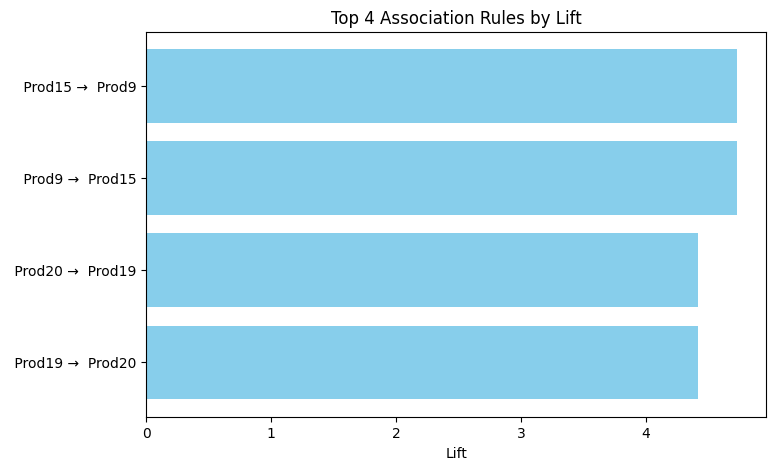

In [ ]:
# Bar chart for lift 
rules['rule_label'] = rules['antecedents'].apply(lambda x: ', '.join(list(x))) + " → " + rules['consequents'].apply(lambda x: ', '.join(list(x)))
plt.figure(figsize=(8,5))
plt.barh(rules['rule_label'], rules['lift'], color='skyblue')
plt.xlabel('Lift')
plt.title('Top 4 Association Rules by Lift')
plt.gca().invert_yaxis()  # largest lift on top
plt.show()

The company can use these rules to create product bundles which could result in increased revenues. The rules are:
1. If a client buys Prod15, they are likely to also buy Prod9.
2. If a client buys Prod9, they are likely to also buy Prod15.
3. If a client buys Prod20, they are likely to also buy Prod19.
4. If a client buys Prod19, they are likely to also buy Prod20.

As these rules are pretty much pairwise, the company should create two bundles based on these rules: one bundle with Prod15 and Prod9 and another bundle with Prod20 and Prod19. Also a discount could be offered for buying the products together.

## 6. Deployment

The clustering algorithm may be used to evaluate the locations of the drone depot stations, but also other factors should be considered before making the final desicisions and locations. The scatter plots for the clusters can be used to visualize the clusters in relevance to the locations of the clients. The company should also consider how far the drone delivery can reach and how much it costs to set up a drone depot station. The product of this analysis is not a software or a model that can be deployed, but rather gathers insights that can be used to make decisions about the locations of the drone depot stations. The model may be rerun if the data changes for example if the clientele changes or if the company expands to new areas.

The association rules can be used to create product bundles for the drone delivery service. The company can use the rules to find out which products are often bought together and create bundles based on that. The bundles can then be marketed to customers and a discount could be offered for buying the products together. The recommendations of this analysis is to create two bundles: Prod15 and Prod9 as one bundle and Prod20 and Prod19 as another bundle. The model may be rerun if the sales data changes for example if new products are added or if the customer preferences change.